In [1]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# OBSERVADOR DE ESTADO DE ORDEM MÍNIMA

In [2]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [3]:
s = ctl.TransferFunction.s

G = 1/(s*(s+1)*(s+2))
G

TransferFunction(array([1]), array([1, 3, 2, 0]))

polos:  (-2+0j) (-1+0j) 0j
zeros: 


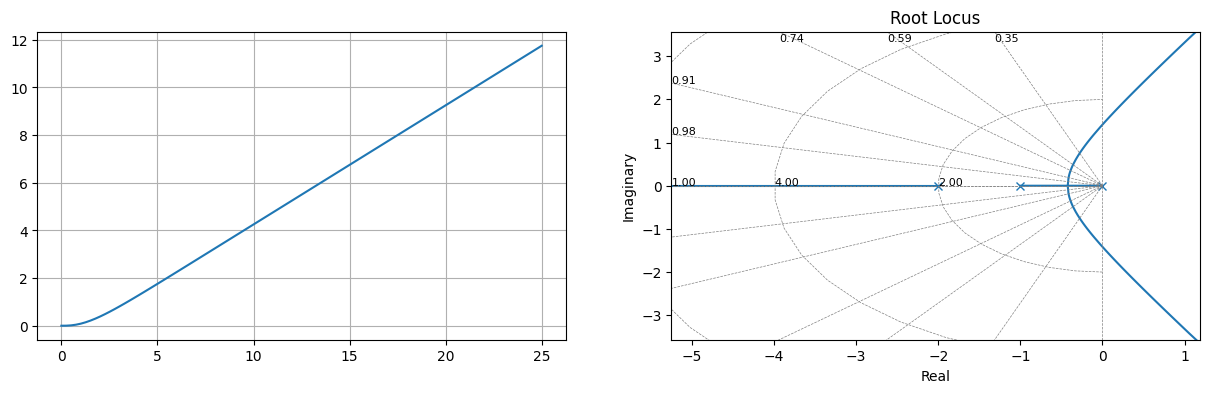

In [4]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

# REQUISITOS DE CONTROLE

(0.4559498107691261, 1.754579081084621, -0.8 + 1.562*I)

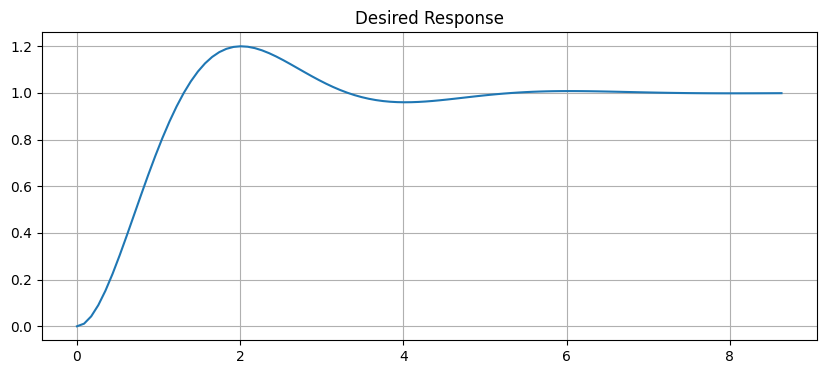

In [5]:
Ts = 5.0
UP = 0.2

zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
Wn = 4/(zeta*Ts)

s_d = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_d = roundSympyFunction(s_d, 3)
G_desired = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

time, response = ctl.step_response(G_desired)
plt.figure(figsize=(10, 4))
plt.plot(time, response)
plt.title('Desired Response'), plt.grid()
(zeta, Wn, s_d)

In [6]:
s1 = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*1j
s2 = -zeta*Wn - Wn*np.sqrt(1-zeta**2)*1j
s3 = -15                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s4 = -15                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s5 = -15                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)

p = [np.round(val, 3) for val in [s1, s2]]
p

[(-0.8+1.562j), (-0.8-1.562j)]

# ESPAÇO DE ESTADOS
- Forma padrão (computacional)

In [7]:
matrix = ctl.tf2ss(G)
A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D

display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[-3.0, -2.0, 0],
[ 1.0,    0, 0],
[   0,  1.0, 0]])

Matrix([
[1.0],
[  0],
[  0]])

Matrix([[0, 0, 1.0]])

Matrix([[0]])

- Forma variáveis de fase (convencional)

In [8]:
def getVariaveisFase(G):
    matrix = ctl.tf2ss(G)
    A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D
    
    n = A.shape[0]

    # Cria uma matriz P com elementos 1 na diagonal secundária
    P = np.fliplr(np.eye(n))

    # Calcula a inversa da matriz P
    P_inv = np.linalg.inv(P)

    # Realiza as operações para obter a forma de variáveis de fase
    A = P_inv @ A @ P
    B = P_inv @ B
    C = C @ P
    D = D
    
    return A, B, C, D

A, B, C, D = getVariaveisFase(G)
display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[0,  1.0,    0],
[0,    0,  1.0],
[0, -2.0, -3.0]])

Matrix([
[  0],
[  0],
[1.0]])

Matrix([[1.0, 0, 0]])

Matrix([[0]])

In [9]:
A_aa = np.array([A[0, 0]])
A_ab = np.array([A[0, 1:]])
A_ba = np.array(A[1:, 0])
A_bb = np.array(A[1:, 1:])

B_a = np.array([B[0, 0]])
B_b = np.array(B[1:, 0])

display(sp.Matrix(A_aa))
display(sp.Matrix(A_ab))
display(sp.Matrix(A_ba))
display(sp.Matrix(A_bb))
display(sp.Matrix(B_a))
display(sp.Matrix(B_b))

Matrix([[0]])

Matrix([[1.0, 0]])

Matrix([
[0],
[0]])

Matrix([
[   0,  1.0],
[-2.0, -3.0]])

Matrix([[0]])

Matrix([
[  0],
[1.0]])

In [10]:
n = sp.shape(A_bb)[0]
n

2

# CONTROLADOR

In [11]:
K = ctl.acker(A, B, p)
#K = ctl.place(A, B, p)

sp.Matrix(K)

Matrix([[3.079844, 1.6, 1.0]])

In [12]:
L = ctl.acker(A_bb.T, A_ab.T, p).T
#L = ctl.place(A_bb.T, A_ab.T, p).T

L = sp.Matrix(L)
L

Matrix([
[    -1.4],
[5.279844]])

In [13]:
s = sp.symbols('s')
I = sp.eye(n) 

A_aa, A_ab, A_ba, A_bb = sp.Matrix(A_aa), sp.Matrix(A_ab), sp.Matrix(A_ba), sp.Matrix(A_bb)
B_a, B_b = sp.Matrix(B_a), sp.Matrix(B_b)

A, B, C, D = sp.Matrix(A), sp.Matrix(B), sp.Matrix(C), sp.Matrix(D)

### CONSTANTES

As constantes do vetor de ganhos K são:

- $\boldsymbol{K_a} = \boldsymbol{K}[1]$
- $\boldsymbol{K_b} = \boldsymbol{K}[2:]$

As constantes das matrizes chapéu são:

- $\boldsymbol{\hat{A}} = \boldsymbol{Abb} - \boldsymbol{L}\,\boldsymbol{Aab}$
- $\boldsymbol{\hat{B}} = \boldsymbol{\hat{A}}\,\boldsymbol{L}+\boldsymbol{Aba}-\boldsymbol{L}\,\boldsymbol{Aaa}$
- $\boldsymbol{\hat{F}} = \boldsymbol{Bb} - \boldsymbol{L}\,\boldsymbol{Ba}$

As constantes das matrizes til são:

- $\boldsymbol{\tilde{A}} = \boldsymbol{\hat{A}} - \boldsymbol{\hat{F}}\,\boldsymbol{Kb}$
- $\boldsymbol{\tilde{B}} = \boldsymbol{\hat{B}} - \boldsymbol{\hat{F}}\,\boldsymbol{Ka}$
- $\boldsymbol{\tilde{C}} = \boldsymbol{-Kb}$
- $\boldsymbol{\tilde{D}} = -(\boldsymbol{Ka}+\boldsymbol{Kb}\,\boldsymbol{L})$

In [14]:
Ka = sp.Matrix([K[0][0]])
Kb = sp.Matrix(np.array([K[0][1:]]))

display(Ka)
display(Kb)

Matrix([[3.079844]])

Matrix([[1.6, 1.0]])

In [15]:
Ahat = A_bb - L*A_ab
Bhat = Ahat*L + A_ba - L*A_aa
Fhat = B_b - L*B_a

display(Ahat)
display(Bhat)
display(Fhat)

Matrix([
[      1.4,  1.0],
[-7.279844, -3.0]])

Matrix([
[  3.319844],
[-5.6477504]])

Matrix([
[  0],
[1.0]])

In [16]:
Atil = Ahat - Fhat*Kb
Btil = Bhat - Fhat*Ka
Ctil = -Kb
Dtil = -(Ka + Kb*L)

display(Atil)
display(Btil)
display(Ctil)
display(Dtil)

Matrix([
[      1.4,  1.0],
[-8.879844, -4.0]])

Matrix([
[  3.319844],
[-8.7275944]])

Matrix([[-1.6, -1.0]])

Matrix([[-6.119688]])

- O controlador é obtido usando $C(s) = -[\boldsymbol{\tilde{C}}\,(s\boldsymbol{I} - \boldsymbol{\tilde{A}})^{-1}\,\boldsymbol{\tilde{B}} + \boldsymbol{\tilde{D}}]$

In [17]:
C = -(Ctil*(s*I - Atil).inv()*Btil + Dtil)
C = C[0].expand().simplify().factor().cancel()
C = roundSympyFunction(C)
C

(0.3588*s**4 + 1.6656*s**3 + 3.6735*s**2 + 3.9417*s + 1.941)/(0.0586*s**4 + 0.3049*s**3 + 0.781*s**2 + 1.0*s + 0.6307)

# RESPOSTA CONTROLADA

In [18]:
s = ctl.TransferFunction.s
C = eval(str(C))
C

TransferFunction(array([0.3588, 1.6656, 3.6735, 3.9417, 1.941 ]), array([0.0586, 0.3049, 0.781 , 1.    , 0.6307]))

In [19]:
G_ma = G*C
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([0.3588, 1.6656, 3.6735, 3.9417, 1.941 ]), array([0.0586, 0.4807, 1.8129, 4.3116, 6.8583, 7.5656, 5.2031, 1.941 ]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

polos:  (-3.018+0j) (-1.301+1.261j) (-1.301-1.261j) (-0.454+1.457j) (-0.454-1.457j) (-0.837+0.857j) (-0.837-0.857j)
zeros:  (-1.3+1.261j) (-1.3-1.261j) (-1.021+0.779j) (-1.021-0.779j)


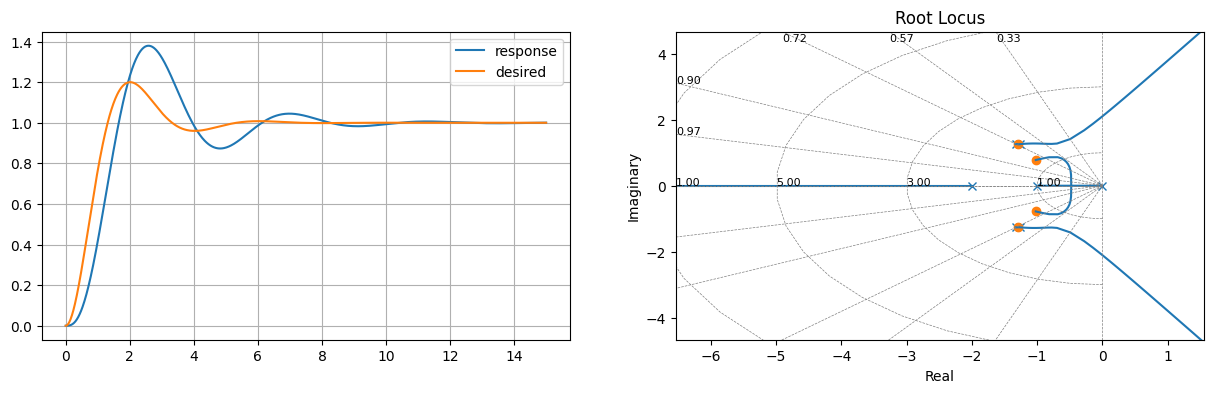

In [20]:
poles = ctl.poles(G_feedback)
zeros = ctl.zeros(G_feedback)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

tData = np.linspace(0, 3*Ts, 1000)
time, response = ctl.step_response(G_feedback, T=tData)
time, desired  = ctl.step_response(G_desired, T=tData)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(time, response, label='response')
plt.plot(time, desired, label='desired')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [21]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.3789602607440848
valor de pico:  1.3796441338924958
tempo de pico:  2.5825825825825826
tempo de assentamento:  7.822822822822823
valor final:  1.000495933906059
erro:  0.0004959339060590651


# APLICANDO VÁRIOS STEPS

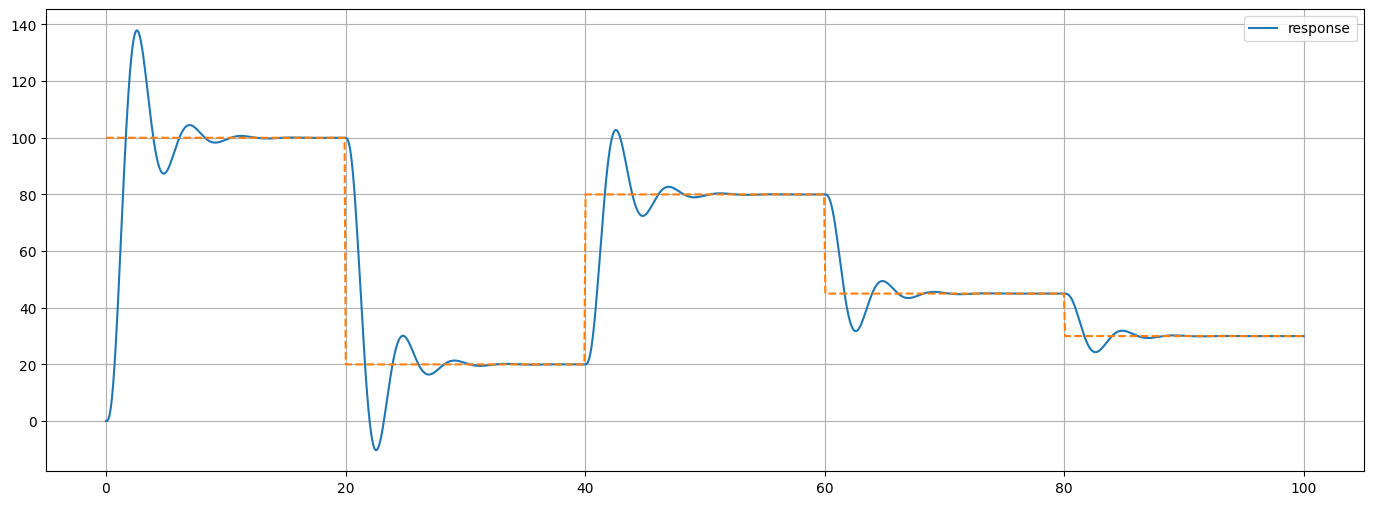

In [22]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array


tData = np.linspace(0, 100, 1000)
uData = makeSteps([100, 20, 80, 45, 30], len(tData))

plt.figure(figsize=(17, 6))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.plot(time, uData, '--')
plt.legend()
plt.grid()